In [ ]:
import torch
import torchvision

In [ ]:
import torchvision.transforms as transforms

########################################################################
# The output of torchvision datasets are PILImage images of range [0, 1].
# We transform them to Tensors of normalized range [-1, 1].

transform = transforms.Compose(
    [transforms.ToTensor()])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=False, num_workers=1)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bbird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
import cv2

rgb_images = []

for image, label in trainset:
    rgb_images.append(image)

In [ ]:
a = rgb_images[1]
a.min()

tensor(0.0196)

In [ ]:
import numpy as np

numpy_lab_images = []  
#l a b

for rgb_image in rgb_images:
    numpy_rgb_image = np.transpose(rgb_image.numpy(), (1, 2, 0))
    numpy_lab_image = cv2.cvtColor(numpy_rgb_image, cv2.COLOR_RGB2LAB)
    numpy_lab_images.append(numpy_lab_image)

In [ ]:
a =  numpy_lab_images[1]
a.max()

99.25537

In [ ]:
a.min()

-23.71875

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow_unimage(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

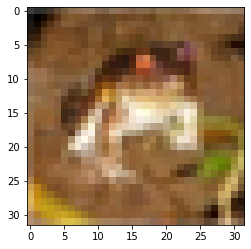

In [ ]:
imshow_unimage(rgb_images[0])

In [ ]:
lab_images = []

for numpy_lab_image in numpy_lab_images:
    numpy_lab_image[:, :, 0] *= 255 / 100
    numpy_lab_image[:, :, 1] += 128
    numpy_lab_image[:, :, 2] += 128
    numpy_lab_image /= 255
    torch_lab_image = torch.from_numpy(np.transpose(numpy_lab_image, (2, 0, 1)))
    lab_images.append(torch_lab_image)

In [ ]:
len(lab_images)

50000

In [ ]:
lab_image = lab_images[1]
lab_image.min()

tensor(0.0168)

In [ ]:
transform = transforms.Compose(
    [transforms.Grayscale(1),
    transforms.ToTensor()])

greytrainset = torchvision.datasets.CIFAR10(root='./grey_data', train=True,
                                        download=True, transform=transform)
greytrainloader = torch.utils.data.DataLoader(greytrainset, batch_size=4,
                                          shuffle=False, num_workers=2)

greytestset = torchvision.datasets.CIFAR10(root='./grey_data', train=False,
                                       download=True, transform=transform)
greytestloader = torch.utils.data.DataLoader(greytestset, batch_size=4,
                                         shuffle=False, num_workers=2)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./grey_data/cifar-10-python.tar.gz to ./grey_data
Files already downloaded and verified


In [ ]:
grey_images = []
for grey_image, label in greytrainset:
    grey_images.append(grey_image)

In [ ]:
grey_images[3].min()

tensor(0.0510)

In [ ]:
# functions to show a greyscale image
def imgreyshow_unimage(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)).reshape((32, 32)), cmap = 'gray')
    plt.show()

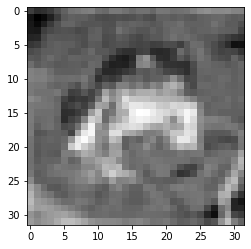

In [ ]:
imgreyshow_unimage(grey_images[0])

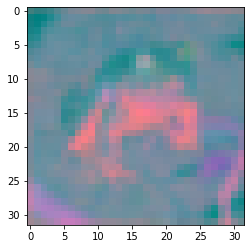

In [ ]:
imshow_unimage(lab_images[0])

In [ ]:
class GreyscaleDataset(torch.utils.data.Dataset):
    """Greyscale dataset."""    
        
    def __len__(self):
        return len(grey_images)

    def __getitem__(self, index):
        img, target = grey_images[index], lab_images[index]
        return img, target

In [ ]:
greyscaleDataset = GreyscaleDataset()

In [ ]:
image, label = greyscaleDataset[1]
image.min()

tensor(0.0235)

In [ ]:
def imshow(img):
    npimg = img.numpy() 
    #denormalization
    npimg = npimg / 2 + 0.5
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
def imgreyshow(img):
    npimg = img.numpy()
    npimg = npimg / 2 + 0.5
    plt.imshow(np.transpose(npimg, (1, 2, 0)).reshape((32, 32)), cmap = 'gray')
    plt.show()    

In [ ]:
greyscaleloader = torch.utils.data.DataLoader(greyscaleDataset, batch_size=128,
                                          shuffle=True, num_workers=2)

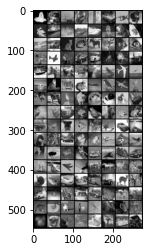

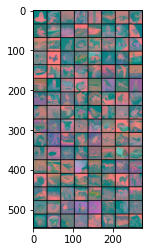

In [ ]:
# get some random training images
dataiter = iter(greyscaleloader)
images, labels = dataiter.next()

# show images
imshow_unimage(torchvision.utils.make_grid(images))
imshow_unimage(torchvision.utils.make_grid(labels))

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class UNet(nn.Module):
    
    def unet_conv(self, ch_in, ch_out, is_leaky):
        if is_leaky:
            return nn.Sequential(
                nn.Conv2d(ch_in, ch_out, 3, padding=1),
                nn.BatchNorm2d(ch_out),
                nn.LeakyReLU(0.2),
                nn.Conv2d(ch_out, ch_out, 3, padding=1),
                nn.BatchNorm2d(ch_out),
                nn.LeakyReLU(0.2)
            )
        else:
            return nn.Sequential(
                nn.Conv2d(ch_in, ch_out, 3, padding=1),
                nn.BatchNorm2d(ch_out),
                nn.ReLU(),
                nn.Conv2d(ch_out, ch_out, 3, padding=1),
                nn.BatchNorm2d(ch_out),
                nn.ReLU()
            )
        
    def up(self, ch_in, ch_out):
        return nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(ch_in, ch_out, 1)
        )
    
    def __init__(self, is_leaky):
        super(UNet, self).__init__()
        
        # First encoding layer
        self.conv1 = self.unet_conv(1, 64, is_leaky)
        # Second encoding layer
        self.conv2 = self.unet_conv(64, 128, is_leaky)
        # Third encoding layer
        self.conv3 = self.unet_conv(128, 256, is_leaky)
        # Fourth encoding layer
        self.conv4 = self.unet_conv(256, 512, is_leaky)
        # Fifth encoding layer
        self.conv5 = self.unet_conv(512, 1024, is_leaky)
        
        # Pooling layer
        self.pool = nn.MaxPool2d(2)
        
        # First Upsampling layer
        self.up1 = self.up(1024, 512)
        # Second Upsampling layer
        self.up2 = self.up(512, 256)
        # Third Upsampling layer
        self.up3 = self.up(256, 128)
        # Fourth Upsampling layer
        self.up4 = self.up(128, 64)
        
        # First decoding layer
        self.conv6 = self.unet_conv(1024, 512, False)
        # Second decoding layer
        self.conv7 = self.unet_conv(512, 256, False)
        # Third decoding layer
        self.conv8 = self.unet_conv(256, 128, False)
        # Fourth decoding layer
        self.conv9 = self.unet_conv(128, 64, False)
        
        # Last layer
        self.conv10 = nn.Conv2d(64, 3, 1)

    def forward(self, x):
        # Encoding path
        x1 = self.conv1(x)
        x2 = self.conv2(self.pool(x1))
        x3 = self.conv3(self.pool(x2))
        x4 = self.conv4(self.pool(x3))
        x5 = self.conv5(self.pool(x4))
        
        # Decoding path
        x = self.conv6(torch.cat((x4, self.up1(x5)), 1))
        x = self.conv7(torch.cat((x3, self.up2(x)), 1))
        x = self.conv8(torch.cat((x2, self.up3(x)), 1))
        x = self.conv9(torch.cat((x1, self.up4(x)), 1))
        x = self.conv10(x)
        m = nn.Tanh()
        x = m(x)
        
        return x

In [ ]:
# GAN's
# Discriminator
class DNet(nn.Module):
    
    def unet_conv(self, ch_in, ch_out):
        return nn.Sequential(
            nn.Conv2d(ch_in, ch_out, 3, padding=1),
            nn.BatchNorm2d(ch_out),
            nn.LeakyReLU(0.2),
            nn.Conv2d(ch_out, ch_out, 3, padding=1),
            nn.BatchNorm2d(ch_out),
            nn.LeakyReLU(0.2)
        )
    
    def __init__(self):
        super(DNet, self).__init__()
        
        # First layer
        self.conv1 = self.unet_conv(4, 64)
        # Second layer
        self.conv2 = self.unet_conv(64, 128)
        # Third layer
        self.conv3 = self.unet_conv(128, 256)
        # Fourth layer
        self.conv4 = self.unet_conv(256, 512)
        # Fifth layer
        self.conv5 = self.unet_conv(512, 1024)
        
        # Pooling layer
        self.pool = nn.MaxPool2d(2)
        
        # Last layer
        self.conv6 = nn.Linear(2 * 2 * 1024, 1)

    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.conv2(self.pool(x1))
        x3 = self.conv3(self.pool(x2))
        x4 = self.conv4(self.pool(x3))
        x5 = self.conv5(self.pool(x4))
        
        x6 = x5.view(-1, 2 * 2 * 1024)
        m = nn.Sigmoid()
        x = m(self.conv6(x6))
        
        return x

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch.optim as optim

generator = UNet(True)
discriminator = DNet()

generator.cuda()




UNet(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256

In [ ]:
discriminator.cuda()

DNet(
  (conv1): Sequential(
    (0): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256

In [ ]:
d_optimizer = optim.Adam(discriminator.parameters(), betas=(0.5, 0.999), lr=0.0002)
g_optimizer = optim.Adam(generator.parameters(), betas=(0.5, 0.999), lr=0.0002)

In [ ]:
d_criterion = nn.BCELoss()
g_criterion_1 = nn.BCELoss()
g_criterion_2 = nn.L1Loss()

In [ ]:
from torch.autograd import Variable
from torch import cat

g_lambda = 100
smooth = 0.1

for epoch in range(10):  # loop over the dataset multiple times
    d_running_loss = 0.0
    g_running_loss = 0.0
    for i, data in enumerate(greyscaleloader, 0):
        gray_images, real_images = data
        
        mean = torch.Tensor([0.5])
        gray_images = gray_images - mean.expand_as(gray_images)
        gray_images = 2 * gray_images
        
        real_images = real_images - mean.expand_as(real_images)
        real_images = 2 * real_images
        
        batch_size = gray_images.shape[0]
        gray_images = Variable(gray_images.cuda())
        real_images = Variable(real_images.cuda())
        
        fake_images = generator(gray_images)
        
        # Train the discriminator
        d_optimizer.zero_grad()

        logits = discriminator(cat([gray_images, real_images], 1))
        d_real_loss = d_criterion(logits, ((1 - smooth) * torch.ones(batch_size,1)).cuda())
        d_real_loss.backward()

        logits = discriminator(cat([gray_images, fake_images], 1))
        d_fake_loss = d_criterion(logits, (torch.zeros(batch_size,1)).cuda())
        d_fake_loss.backward(retain_graph=True)

        d_optimizer.step()

        # Train the generator
        g_optimizer.zero_grad()

        fake_logits = discriminator(cat([gray_images, fake_images], 1))
        g_fake_loss = g_criterion_1(fake_logits, (torch.ones(batch_size,1)).cuda())
        g_fake_loss.backward(retain_graph=True)

        g_image_distance_loss = g_lambda * g_criterion_2(fake_images, real_images)
        g_image_distance_loss.backward()

        g_optimizer.step()
        
        d_loss = d_real_loss.item() + d_fake_loss.item()
        g_loss = g_fake_loss.item() + g_image_distance_loss.item()
        
        # print statistics
        d_running_loss += d_loss
        g_running_loss += g_loss
        if i % 10 == 0:    # print every 100 mini-batches
            print('[%d, %5d] d_loss: %.5f g_loss: %.5f' %
                  (epoch + 1, i + 1, d_running_loss / 10, g_running_loss / 10))
            d_running_loss = 0.0
            g_running_loss = 0.0

    torch.save(generator.state_dict(), '/content/drive/MyDrive/Gan1.pth')
    torch.save(discriminator.state_dict(), '/content/drive/MyDrive/Gan1.pth')
    
print('Finished Training')

[1,     1] d_loss: 0.14292 g_loss: 4.93232
[1,    11] d_loss: 3.12326 g_loss: 17.83946
[1,    21] d_loss: 1.16516 g_loss: 11.02713
[1,    31] d_loss: 0.97074 g_loss: 11.23922
[1,    41] d_loss: 0.67426 g_loss: 10.84903
[1,    51] d_loss: 0.95490 g_loss: 11.42516
[1,    61] d_loss: 0.89562 g_loss: 10.17030
[1,    71] d_loss: 0.72169 g_loss: 10.55569
[1,    81] d_loss: 1.14561 g_loss: 9.73197
[1,    91] d_loss: 0.84370 g_loss: 9.31892
[1,   101] d_loss: 1.34546 g_loss: 9.33639
[1,   111] d_loss: 1.50133 g_loss: 7.37273
[1,   121] d_loss: 1.04937 g_loss: 8.00312
[1,   131] d_loss: 1.34671 g_loss: 8.34388
[1,   141] d_loss: 0.64076 g_loss: 9.75890
[1,   151] d_loss: 0.98982 g_loss: 9.92475
[1,   161] d_loss: 1.45777 g_loss: 7.06857
[1,   171] d_loss: 1.32124 g_loss: 7.10385
[1,   181] d_loss: 1.33438 g_loss: 7.14149
[1,   191] d_loss: 1.23545 g_loss: 7.44479
[1,   201] d_loss: 1.12801 g_loss: 8.03159
[1,   211] d_loss: 1.22778 g_loss: 8.30835
[1,   221] d_loss: 1.67653 g_loss: 7.40127
[1, 

In [ ]:
maxo = 1000000000
for i in range(0, len(grey_images)):
    a = grey_images[i]
    maxi = a.min()
    if maxi < maxo:
        maxo = maxi

In [ ]:
def imlabshow(img):
    npimg = img.numpy()
    npimg = npimg / 2 + 0.5
    numpy_lab_image = np.transpose(npimg, (1, 2, 0))
    numpy_lab_image *= 255
    numpy_lab_image[:, :, 0] /= 255 / 100
    numpy_lab_image[:, :, 1] -= 128
    numpy_lab_image[:, :, 2] -= 128

    numpy_rgb_image = cv2.cvtColor(numpy_lab_image, cv2.COLOR_LAB2RGB)
    plt.imshow(numpy_rgb_image)
    plt.show()

In [ ]:
def imfakeshow(img):
    npimg = img.detach().numpy()
    npimg = npimg / 2 + 0.5     # unnormalize
    numpy_lab_image = np.transpose(npimg, (1, 2, 0))
    numpy_lab_image *= 255
    numpy_lab_image[:, :, 0] /= 255 / 100
    numpy_lab_image[:, :, 1] -= 128
    numpy_lab_image[:, :, 2] -= 128

    numpy_rgb_image = cv2.cvtColor(numpy_lab_image, cv2.COLOR_LAB2RGB)
    plt.imshow(numpy_rgb_image)
    plt.show()

In [ ]:
# get some random training images
dataiter = iter(greyscaleloader)
images1, images2 = dataiter.next()

mean = torch.Tensor([0.5])
images1 = images1 - mean.expand_as(images1)
images1 = 2 * images1
        
images2 = images2 - mean.expand_as(images2)
images2 = 2 * images2

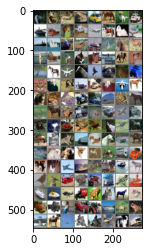

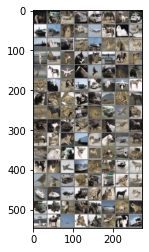

In [ ]:
from torch.autograd import Variable
from torch import cat
images3 = generator(Variable(images1.cuda()))

# show images
imlabshow(torchvision.utils.make_grid(images2))
imfakeshow(torchvision.utils.make_grid(images3.cpu()))

In [ ]:
image = grey_images[1]
image.min()

tensor(0.0235)

In [ ]:
smallgreyscaleloader = torch.utils.data.DataLoader(greyscaleDataset, batch_size=8,
                                          shuffle=True, num_workers=2)

In [ ]:
# get some random training images
dataiter = iter(smallgreyscaleloader)
images1, images2 = dataiter.next()

mean = torch.Tensor([0.5])
images1 = images1 - mean.expand_as(images1)
images1 = 2 * images1
        
images2 = images2 - mean.expand_as(images2)
images2 = 2 * images2

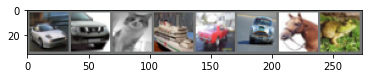

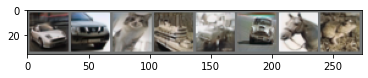

In [ ]:
images3 = generator(Variable(images1.cuda()))

# show images
imlabshow(torchvision.utils.make_grid(images2))
imfakeshow(torchvision.utils.make_grid(images3.cpu()))

In [ ]:
from PIL import Image
imsize=64
loader = transforms.Compose([transforms.Grayscale(1), transforms.ToTensor()])

def image_loader(image_name):
    """load image, returns cuda tensor"""
    image = Image.open(image_name)
    image = loader(image).float()
    image = Variable(image, requires_grad=True)
    # mean = torch.Tensor([0.5])
    # image = image - mean.expand_as(image)
    # image = 2 * image
    image = image.unsqueeze(0)  
    return image.cuda()  

image = image_loader('/content/41_dog.png')



In [ ]:
im3=generator(image)

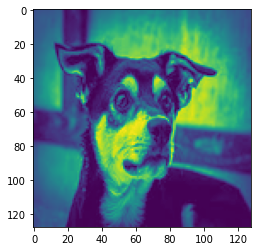

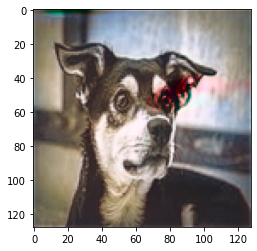

In [ ]:

img2  = Image.open('/content/41_dog.png')
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img=mpimg.imread('/content/41_dog.png')
imgplot = plt.imshow(img)
plt.show()
imfakeshow(torchvision.utils.make_grid(im3.cpu()))